# ICR - Identifying Age-Related Conditions
Вихляев Е.С., ММТ-21

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import KFold

### Задача

Определить, есть ли у человека какое-либо их трех заболеваний. Метка класса 1 соответствует тому, что есть хотя бы одно заболевание, а метка класса 0 соответствует тому, что заболеваний нет.

### Описание датасета

- train.csv - тренировочный набор.
    - Id - уникальный идентификатор для каждого наблюдения.
    - AB-GL - 56 обезличенных характеристик здоровья. Каждая из них числовая, за исключением EJ, которая является категориальной.
    - Class - целевая переменная. 1 указывает на то, что у испытуемого было диагностировано одно из трех заболеваний, 0 указывает на то, что у него заболеваний нет.
- test.csv - тестовый набор. Нужно предсказать вероятность того, что испытуемый из этого набора принадлежит к одному из двух классов.
- greeks.csv - дополнительные метаданные, доступные только для тренировочного набора.
    - Alpha - определяет тип возрастного заболевания, если таковое имеется.
        - A - нет возрастных изменений. Соответствует классу 0.
        - B, D, G - три возрастных изменения. Соответствует классу 1.
    - Beta, Gamma, Delta - три эксперементальных характеристики.
    - Epsilon - дата, когда были собраны данные по данному субъекту. Обратите внимание, что все данные в тестовом наборе были собраны после того, как был собран тренировочный набор данных.
- sample_submission.csv - образец файла для отправки в нужном формате.

[Источник](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview).

### Загрузка датасета

In [2]:
df = pd.read_csv('train.csv')
print('Полный размер тренировочного датасета:', df.shape)

Полный размер тренировочного датасета: (617, 58)


Имеем 58 столбцов и 617 записей.

In [3]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


Видим, что в датасете явно выделена целевая переменная class, по которой и будем проводить классификацию. Здесь метка класса 1 указывает, есть ли у человека одно или более из представленных трех заболеваний. Метка класса 0 указывает, что у человека нет ни одного из трех заболеваний.

### EDA

In [4]:
df.describe(include='all')

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
unique,617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ffcca4ded3bb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,NaN,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,NaN,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,NaN,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,NaN,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,NaN,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [6]:
df.shape

(617, 58)

Посмотрим на круговую диаграмму распределения целевой переменной.

<Axes: ylabel='count'>

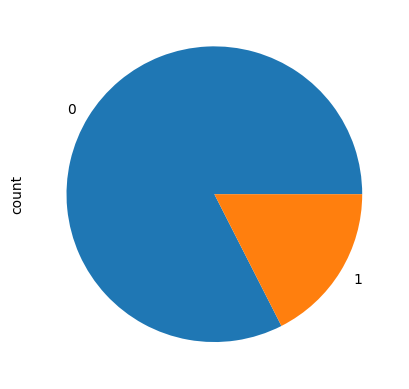

In [7]:
plot_df = df.Class.value_counts()
plot_df.plot(kind='pie')

Из диаграммы видим, что наш датасет имеет сильный дисбаланс классов в пользу метки класса 1.

Далее рассмотрим распределение числовых данных.

Для начала выделим все численные столбцы наших признаков, то есть исключим из рассмотрения очевидные числовые столбцы как Id, EJ и столбец целевой переменной Class.

In [8]:
num_feature_columns = [i for i in df.columns if i not in ['Id', 'EJ', 'Class']]
#num_feature_columns

Изобразим первые 6 числовых столбца и их значения через bag charts.

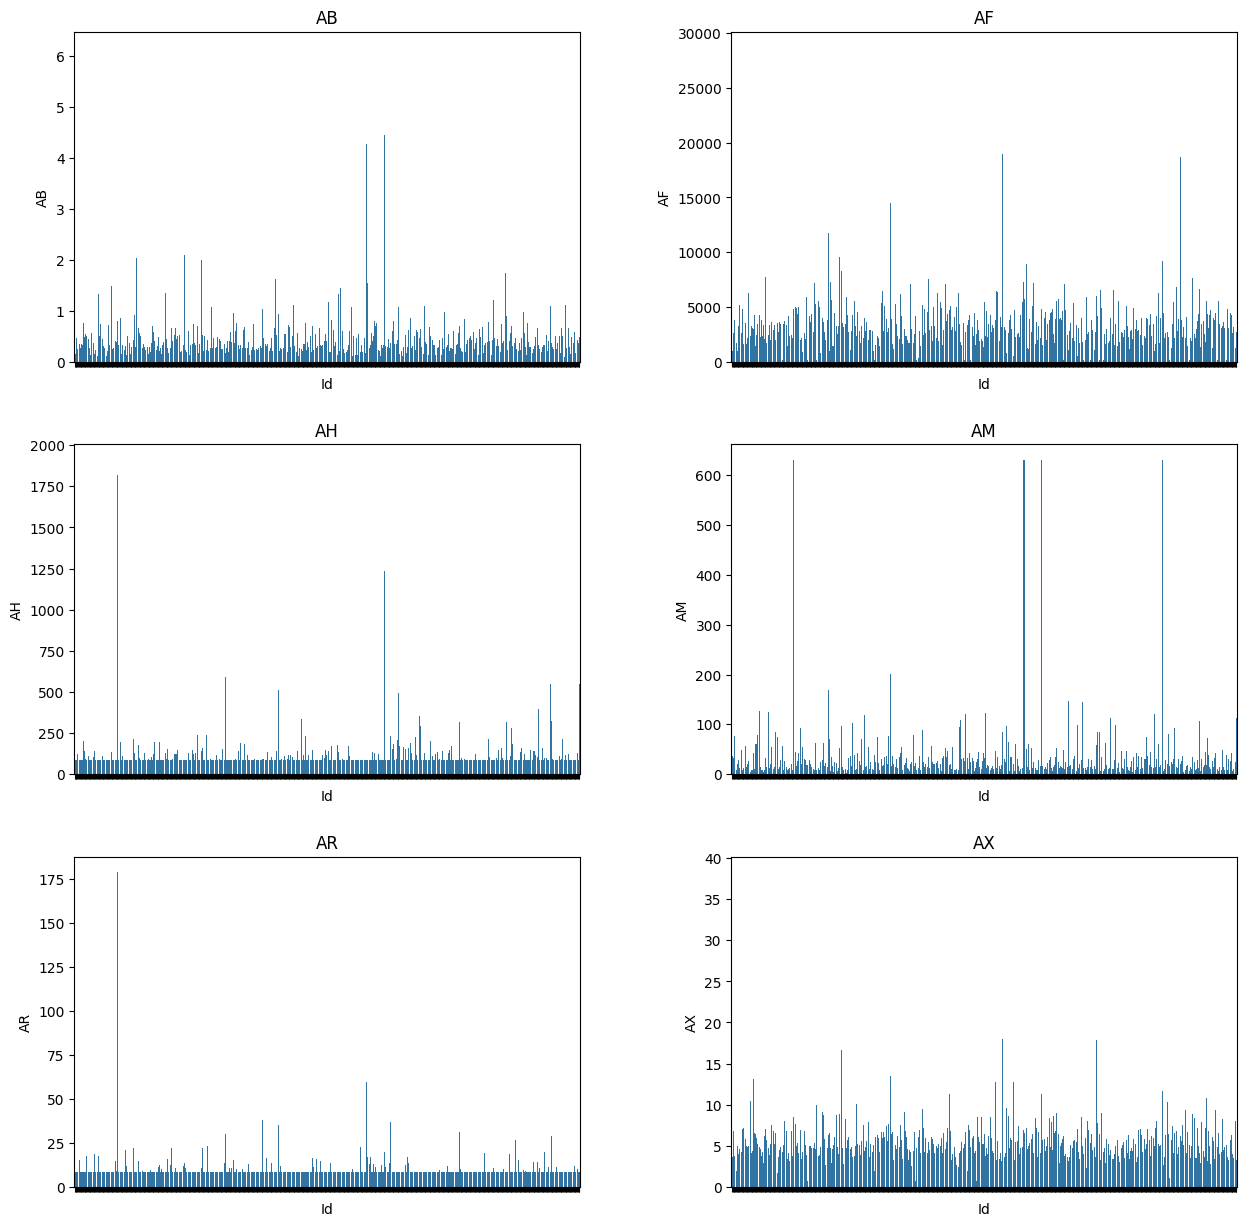

In [9]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(num_feature_columns[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=df['Id'], y = df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)

plt.show()

Так же выделим столбцы признаков отдельно.

In [10]:
feature_columns = [i for i in df.columns if i not in ['Id']]
#feature_columns

### Пропущенные значения

Рассмотрим пропущенные значения.

In [11]:
print(df.isnull().sum())

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64


In [12]:
print(df.isnull().sum().sum())

131


Как мы видим, всего в датафрейме 131 пропуск. Определим, случайны ли наши пропуски или нет.

In [13]:
import missingno as msno
sns.set()

<Axes: >

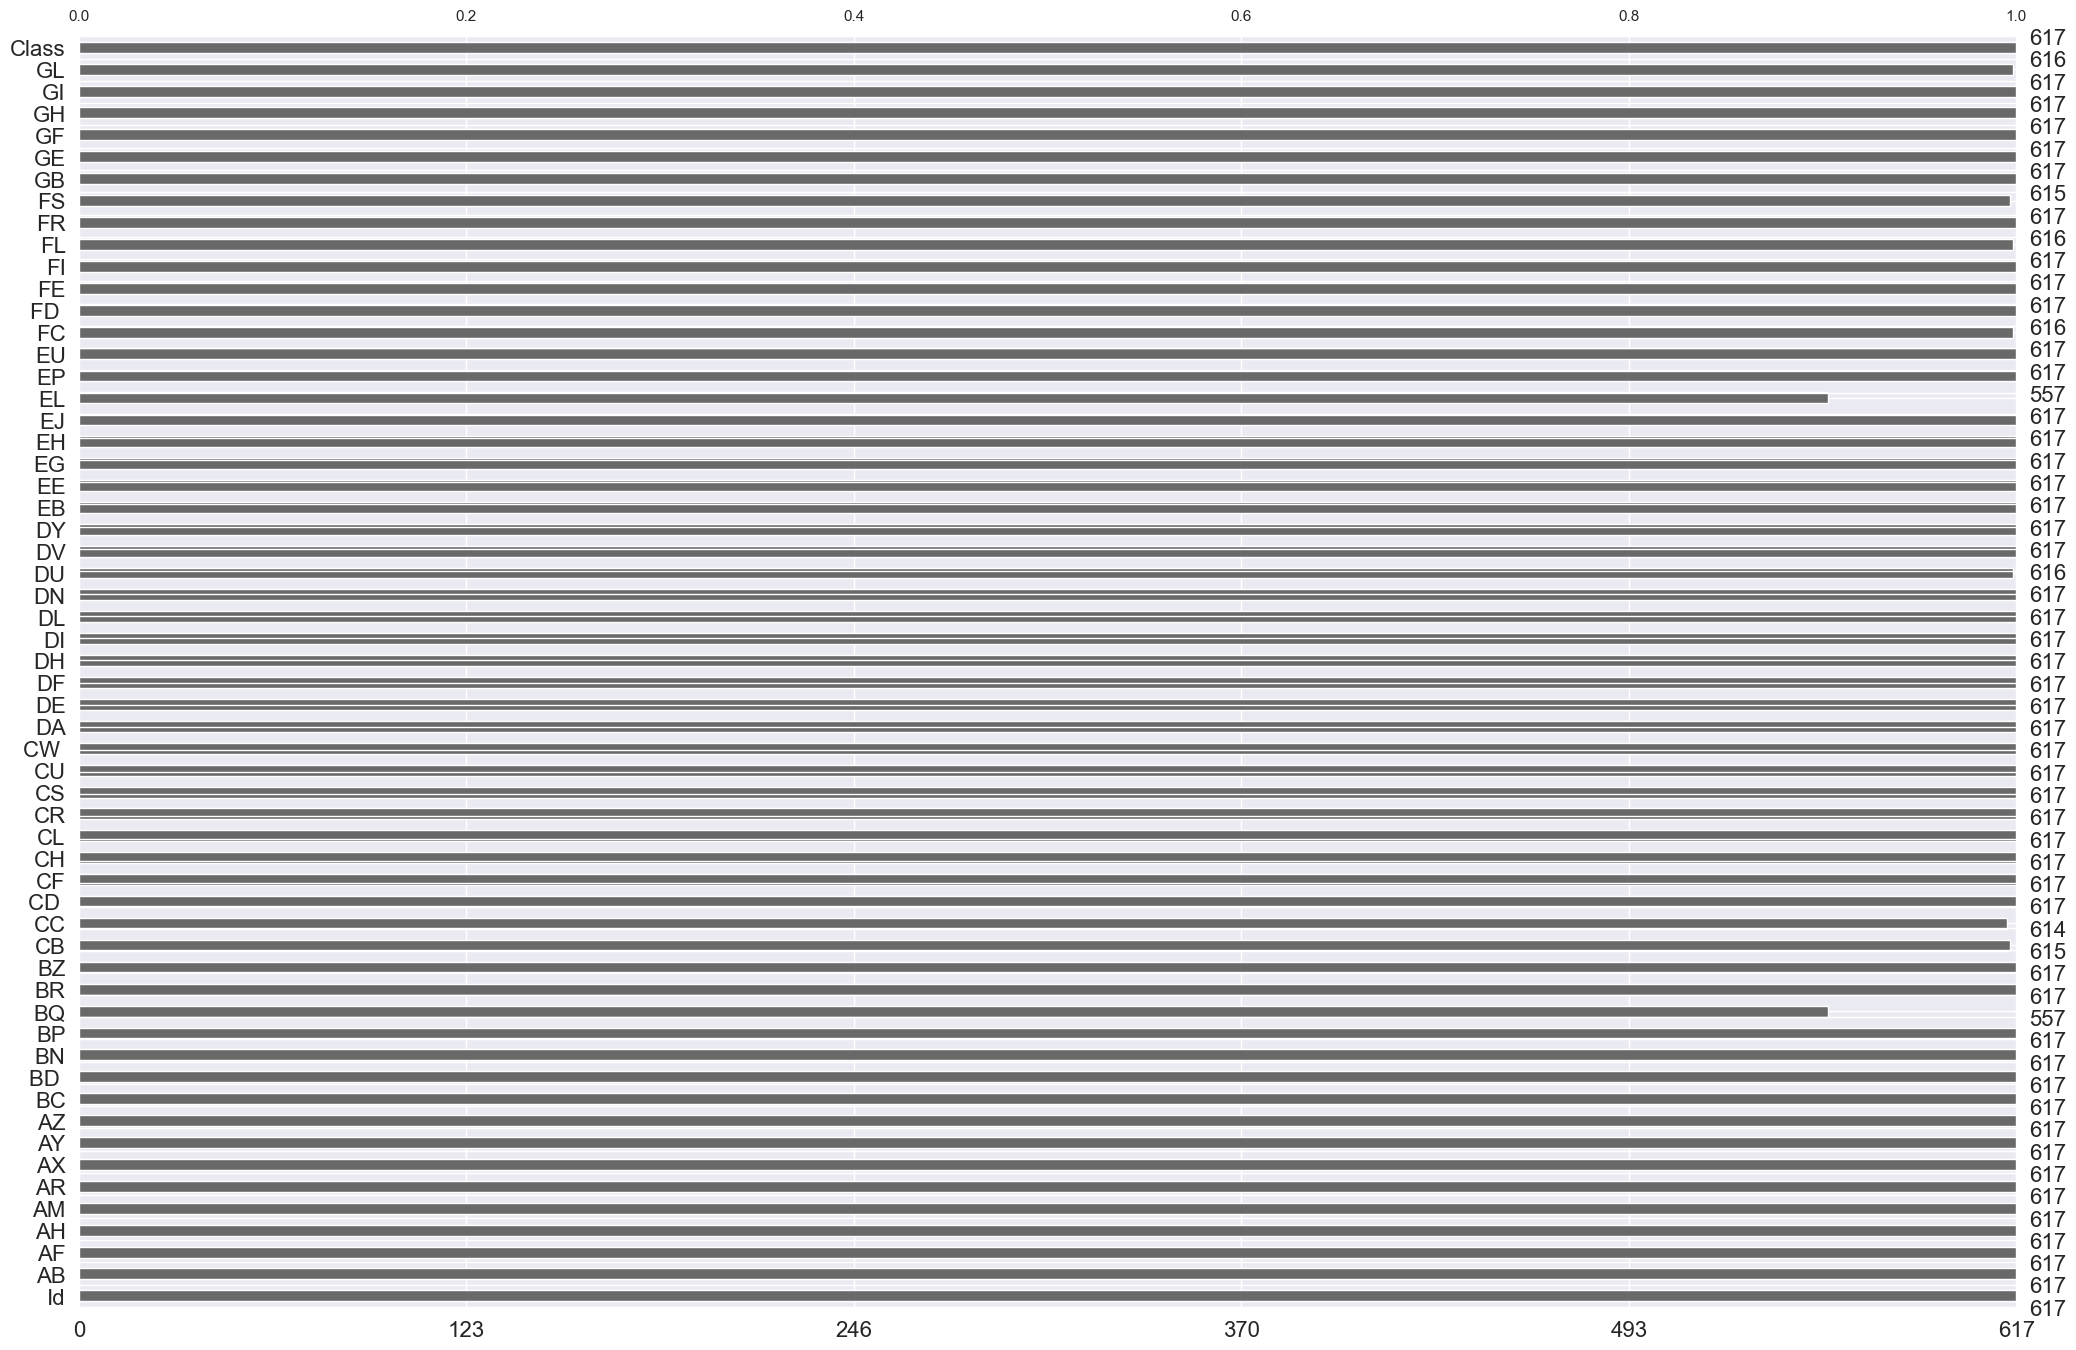

In [14]:
msno.bar(df)

<Axes: >

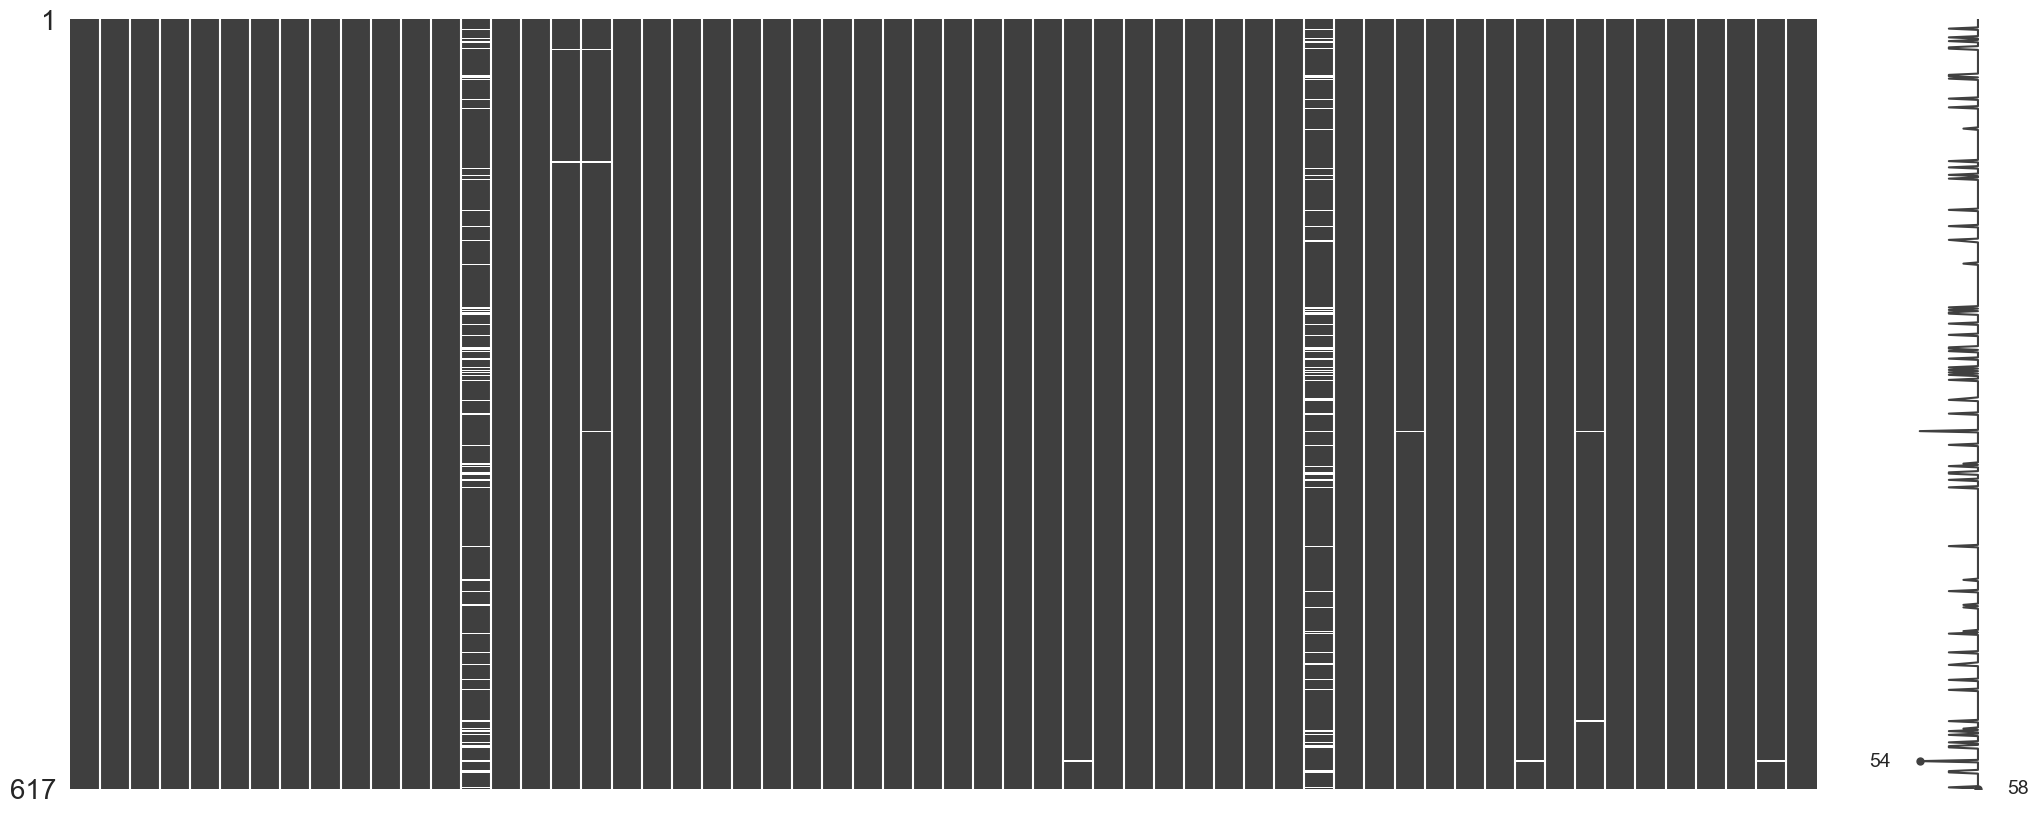

In [15]:
msno.matrix(df)

In [16]:
missing_columns = df.columns[df.isnull().any()].tolist()
print("Столбцы с пропущенными значениями:", missing_columns)

Столбцы с пропущенными значениями: ['BQ', 'CB', 'CC', 'DU', 'EL', 'FC', 'FL', 'FS', 'GL']


In [17]:
miss = df.columns[df.isnull().any()]

In [18]:
df[miss].isnull().corr()

,BQ,CB,CC,DU,EL,FC,FL,FS,GL
BQ,1.000000,-0.018717,-0.022942,0.122761,0.870766,-0.013224,0.122761,0.077518,0.122761
CB,-0.018717,1.000000,0.815832,-0.002298,-0.018717,-0.002298,-0.002298,-0.003252,-0.002298
CC,-0.022942,0.815832,1.000000,-0.002816,0.055697,0.576412,-0.002816,0.405923,-0.002816
DU,0.122761,-0.002298,-0.002816,1.000000,-0.013224,-0.001623,1.000000,-0.002298,1.000000
EL,0.870766,-0.018717,0.055697,-0.013224,1.000000,0.122761,-0.013224,0.077518,-0.013224
FC,-0.013224,-0.002298,0.576412,-0.001623,0.122761,1.000000,-0.001623,0.706533,-0.001623
FL,0.122761,-0.002298,-0.002816,1.000000,-0.013224,-0.001623,1.000000,-0.002298,1.000000
FS,0.077518,-0.003252,0.405923,-0.002298,0.077518,0.706533,-0.002298,1.000000,-0.002298
GL,0.122761,-0.002298,-0.002816,1.000000,-0.013224,-0.001623,1.000000,-0.002298,1.000000


In [19]:
df['EJ'].isnull().any().sum()

np.int64(0)

В единственном категориальном признаке пропуски отсутствуют. Это упрощает работу.

<Axes: >

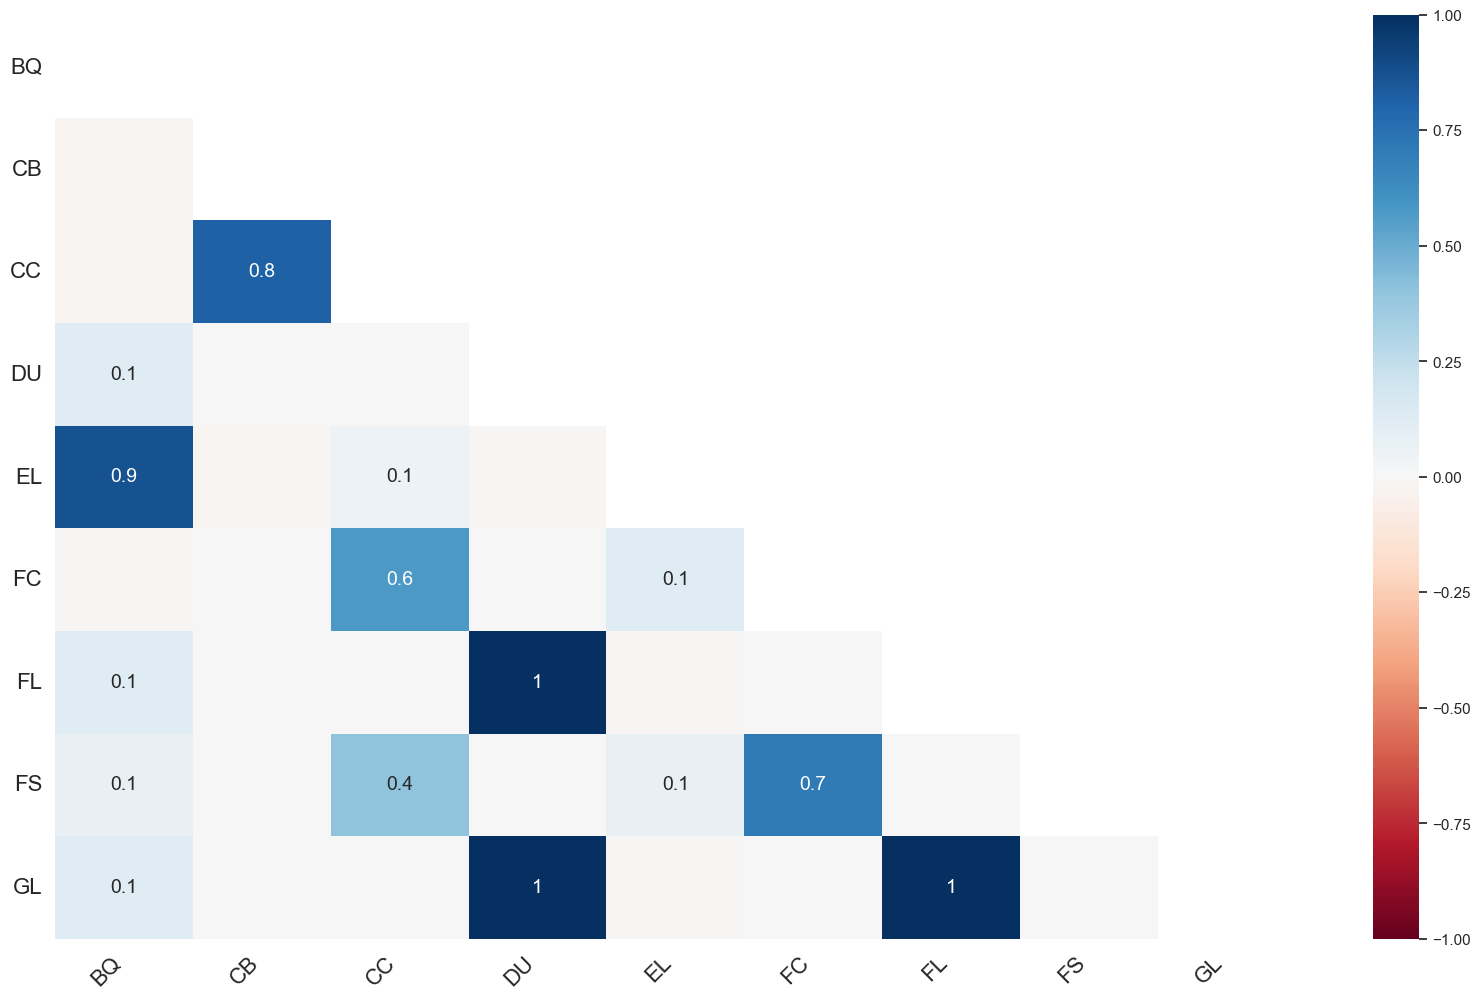

In [20]:
msno.heatmap(df)

Итак, видим, что три признака (DU, FL, GL) коррелируют с максимальным коэффицентом 1, признаки EL, CC, CB BQ коррелируют с очень высокими коэффициентами, еще FS, CC, FC коррелируют с серьзными коэффициентами. Иными словами, корреляция присутствует и достаточно сильная.

Соответственно, удалять пропуски в нашем случае — совершенно не вариант. **Значит их следует заменить.** Замене подлежат: DU, FL, GL, EL, CC, CB, BQ, FS, FC.

Поскольку признаки отражают некоторые характеристики здоровья, то мы можем заменить пропуски средним арифметическим или медианой. Как говорится, «средняя температура по больнице». Но здесь сушествует два важных момента:

1. Среднее значение может не отражать истинное состояние данных, если они содержат выбросы или имеют сильно ассиметричное распределение. Это может привести к искажению результатов.
2. Медиана же менее чувствительна к выбросам, а потому может быть более подходящей, если у данных ассиметричное распределение.

Проверим выбросы.

<Axes: >

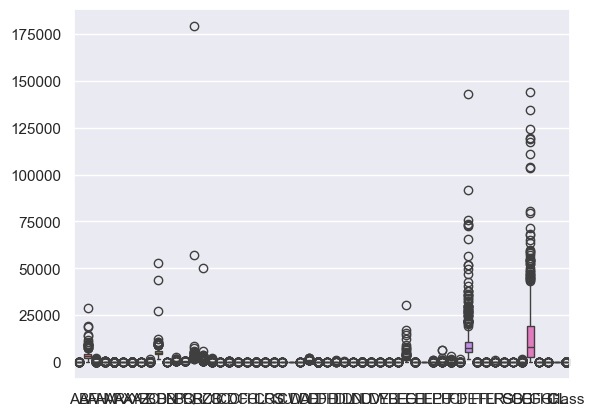

In [21]:
sns.boxplot(df)

In [22]:
def find_outliers_iqr(df):
    outlier_counts = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]
    
    return outlier_counts

df_outliers = df.drop('Id', axis=1)

# Выявление выбросов
element_counts = {column: len(df_outliers[column]) for column in df_outliers.columns}
print("Количество элементов в каждом столбце:")
print(element_counts)
outliers_iqr = find_outliers_iqr(df)
print("Количество выбросов в каждом столбце:")
print(outliers_iqr)

Количество элементов в каждом столбце:
{'AB': 617, 'AF': 617, 'AH': 617, 'AM': 617, 'AR': 617, 'AX': 617, 'AY': 617, 'AZ': 617, 'BC': 617, 'BD ': 617, 'BN': 617, 'BP': 617, 'BQ': 617, 'BR': 617, 'BZ': 617, 'CB': 617, 'CC': 617, 'CD ': 617, 'CF': 617, 'CH': 617, 'CL': 617, 'CR': 617, 'CS': 617, 'CU': 617, 'CW ': 617, 'DA': 617, 'DE': 617, 'DF': 617, 'DH': 617, 'DI': 617, 'DL': 617, 'DN': 617, 'DU': 617, 'DV': 617, 'DY': 617, 'EB': 617, 'EE': 617, 'EG': 617, 'EH': 617, 'EJ': 617, 'EL': 617, 'EP': 617, 'EU': 617, 'FC': 617, 'FD ': 617, 'FE': 617, 'FI': 617, 'FL': 617, 'FR': 617, 'FS': 617, 'GB': 617, 'GE': 617, 'GF': 617, 'GH': 617, 'GI': 617, 'GL': 617, 'Class': 617}
Количество выбросов в каждом столбце:
{'AB': 35, 'AF': 19, 'AH': 70, 'AM': 54, 'AR': 133, 'AX': 27, 'AY': 107, 'AZ': 14, 'BC': 45, 'BD ': 15, 'BN': 14, 'BP': 33, 'BQ': 48, 'BR': 47, 'BZ': 116, 'CB': 47, 'CC': 25, 'CD ': 37, 'CF': 38, 'CH': 30, 'CL': 74, 'CR': 31, 'CS': 31, 'CU': 21, 'CW ': 0, 'DA': 19, 'DE': 38, 'DF': 137, '

Выбросов достаточно много, поэтому воспользуемся заменой на медиану. Замене подлежат: DU, FL, GL, EL, CC, CB, BQ, FS, FC.

In [23]:
from sklearn.impute import SimpleImputer

median_imputer = df.copy()
print('Пропусков:',median_imputer.isna().sum().sum())
imp_median = SimpleImputer(strategy = 'median')
median_imputer[['DU', 'FL', 'GL', 'EL', 'CC', 'CB', 'BQ', 'FS', 'FC']] = imp_median.fit_transform(median_imputer[['DU', 'FL', 'GL', 'EL', 'CC', 'CB', 'BQ', 'FS', 'FC']])
print('Пропусков после их заполенения медианой: ', median_imputer.isna().sum().sum())

Пропусков: 131
Пропусков после их заполенения медианой:  0


### Работа с категориальными признаками

In [24]:
print(df.dtypes)

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object


Видим, что столбец Id содержит уникальные идентификаторы пациентов, а значит данные значения можно расценивать как категориальные. Помимо этого, признак EJ так же является категориальным!

Для кодирования категориальных данных воспользуемся методом One-Hot.

In [25]:
df_encoded = pd.get_dummies(df)
df_encoded

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,Id_fbc241daef00,Id_fbd12c4ae88b,Id_fd1dd68d51b4,Id_fd3dafe738fd,Id_fd895603f071,Id_fd8ef6377f76,Id_fe1942975e40,Id_ffcca4ded3bb,EJ_A,EJ_B
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,False,False,False,False,False,False,False,False,False,True
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,False,False,False,False,False,False,False,False,True,False
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,False,False,False,False,False,False,False,False,False,True
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,False,False,False,False,False,False,False,False,False,True
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,False,False,False,True,False,False,False,False,True,False
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,False,False,False,False,True,False,False,False,False,True
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,False,False,False,False,False,True,False,False,True,False
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,False,False,False,False,False,False,True,False,False,True


Можем заметить, что количество столбцов сильно увеличилось (с 58 до 675). Это слишком большая разница, а потому **воспользуемся методом главных компонент (PCA), чтобы сократить размерность**.

In [28]:
from sklearn.decomposition import PCA

df_without_id = df.drop('Id', axis=1)

pca = PCA(n_components=58)
XPCAreduced = pca.fit_transform(df_without_id)

pca_df = pd.DataFrame(data=XPCAreduced)

ValueError: could not convert string to float: 'B'

In [54]:
df.AB

0      0.209377
1      0.145282
2      0.470030
3      0.252107
4      0.380297
         ...   
612    0.149555
613    0.435846
614    0.427300
615    0.363205
616    0.482849
Name: AB, Length: 617, dtype: float64